In [1]:
import argparse
from collections import defaultdict

import spacy
from spacy.tokens import Doc, DocBin, Token

from mwe_detector.model import MWEDetector
from config import SPACY_MODEL

In [2]:

LANG_CODE = 'fr'
TEST_DATA_PATH = "/home/till/VSCode/mwe-detection/data/sequoia/sequoia-ud.parseme.frsemcor"
TEST_DATA_PATH = "/home/till/VSCode/mwe-detection/data/sequoia/sequoia-ud.parseme.frsemcor.cupt.spacy"

In [3]:
nlp = spacy.load(SPACY_MODEL[LANG_CODE])
if not Token.has_extension("wikt_mwe"):
    Token.set_extension("wikt_mwe", default="*")
if not Token.has_extension("parseme_mwe"):
    Token.set_extension("parseme_mwe", default="*")

In [4]:
mweDetector = MWEDetector(nlp)
mweDetector.from_disk("mwe_detector/data")

In [5]:
from load_cupt_to_spacy import load_cupt_to_spacy
test_data = load_cupt_to_spacy(TEST_DATA_PATH, nlp, "parseme:mwe")

In [6]:
def get_spans_of_pred(tags, doc):
    mwes = defaultdict(lambda: {"span": [], "lemmas":[]})
    for i, tag in enumerate(tags):
        labels = tag.split(", ")
        for label in labels:
            match_id = label.split(":")[0]
            rest = label[len(match_id) + 1 :]
            if match_id and match_id != "*":
                mwes[match_id]["span"].append(i)
                if ":" in rest:
                    lemma, pos = rest.split(":")
                    mwes[match_id]["lemma"] = lemma
                    mwes[match_id]["pos"] = pos
                    mwes[match_id]["lemmas"].append(doc[i].lemma_)

                    

    return list(mwes.values())


def get_spans_of_target(tags, doc):
    mwes = defaultdict(lambda: {"span": [], "lemmas":[]})
    for i, tag in enumerate(tags):
        labels = tag.split(";")
        for label in labels:
            match_id = label.split(":")[0]
            rest = label[len(match_id) + 1 :]
            if match_id and match_id != "*":
                mwes[match_id]["span"].append(i)
                mwes[match_id]["lemmas"].append(doc[i].lemma_)
                if "|" in rest:
                    pos, type, misc = rest.split("|")
                    mwes[match_id]["pos"] = pos
                    mwes[match_id]["type"] = type
                    mwes[match_id]["misc"] = misc
            
    return list(mwes.values())



In [7]:
preds = []
targets = []

for doc in test_data:
    doc = mweDetector(doc)
    pred = [tok._.wikt_mwe for tok in doc]
    target = [tok._.parseme_mwe for tok in doc]
    pred_spans = get_spans_of_pred(pred, doc)
    target_spans = get_spans_of_target(target, doc)
    target_spans = list(filter(lambda x: len(x["span"]) > 1, target_spans))

    preds.append(pred_spans)
    targets.append(target_spans)


In [8]:
mwes_lemmas_train = [mwe["lemmas"] for mwe in mweDetector._data.mwes.values()]

mwes_lemmas_test = [[doc[i].lemma_ for i in target['span']] for targets, doc in zip(targets, test_data) for target in targets]

print(f"Number of MWES in train: {len(mwes_lemmas_train)}")
print(f"Number of MWES in test: {len(mwes_lemmas_test)}")

mwes_lemmas_train_unique = set([tuple(sorted(mwe)) for mwe in mwes_lemmas_train])
mwes_lemmas_test_unique = set([tuple(sorted(mwe)) for mwe in mwes_lemmas_test])


print(f"Number of unique MWES in train: {len(mwes_lemmas_train_unique)}")
print(f"Number of unique MWES in test: {len(mwes_lemmas_test_unique)}")

Number of MWES in train: 68
Number of MWES in test: 4511
Number of unique MWES in train: 65
Number of unique MWES in test: 2121


In [9]:
def update_results(predictions, targets):
    for pred, target in zip(predictions, targets):
        pred_spans = {tuple(sorted(mwe["span"])) for mwe in pred}
        target_spans = {tuple(sorted(mwe["span"])) for mwe in target}

        for mwe in pred:
            lemmas = tuple(sorted(mwe["lemmas"]))
            seen = lemmas in mwes_lemmas_test_unique
            mwe["result"] = "TP" if tuple(sorted(mwe["span"])) in target_spans else ("FP-unseen" if not seen else "FP")

        for mwe in target:
            lemmas = tuple(sorted(mwe["lemmas"]))
            seen =  lemmas in mwes_lemmas_train_unique
            mwe["result"] = "TP" if tuple(sorted(mwe["span"])) in pred_spans else ("FN-unseen" if not seen else "FN")

    return predictions, targets

preds, targets = update_results(preds, targets)


In [10]:
TP_pred, TP_target, FP, FN, FPUnseen, FNUnseen = 0, 0, 0, 0, 0, 0

for pred, target in zip(preds, targets):
    for mwe in pred:
        if mwe["result"] == "TP":
            TP_pred += 1
        elif mwe["result"] == "FP-unseen":
            FPUnseen += 1
        elif mwe["result"] == "FP":
            FP += 1
        else:
            print(mwe)

    for mwe in target:
        if mwe["result"] == "TP":
            TP_target += 1
        elif mwe["result"] == "FN-unseen":
            FNUnseen += 1
        elif mwe["result"] == "FN":
            FN += 1
        else:
            print(mwe)

In [11]:
print(f"TP_pred: {TP_pred}")
print(f"TP_target: {TP_target}")
print(f"FP: {FP}")
print(f"FN: {FN}")
print(f"FPUnseen: {FPUnseen}")
print(f"FNUnseen: {FNUnseen}")

TP_pred: 18
TP_target: 18
FP: 0
FN: 93
FPUnseen: 22
FNUnseen: 4400


In [12]:
def get_metrics(TP, FP, FN):
  precision = TP / (TP + FP) if TP + FP > 0 else 0
  recall =  TP / (TP + FN) if TP + FN > 0 else 0
  FHalf = 5* precision * recall / (precision + 4 *  recall) if precision + recall > 0 else 0
  return precision, recall, FHalf

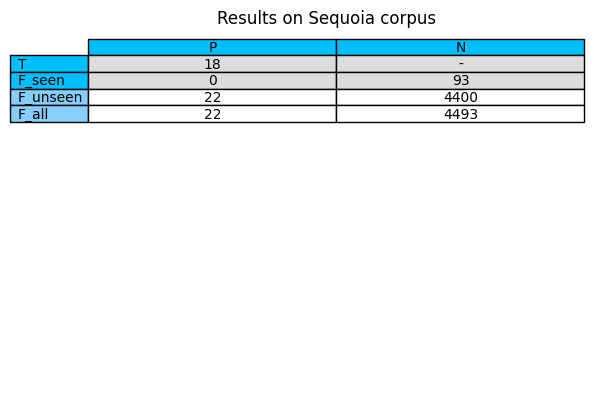

           	F1   	Precision	Recall
Seen       	0.49		1.00	0.16
Seen+Unseen	0.02		0.45	0.00


In [13]:
import matplotlib.pyplot as plt 

def pretty_print_unseen_evaluation(TP, FP_seen, FN_seen, FP_unseen, FN_unseen, title=''):
  values = [[TP, '-'], [FP_seen, FN_seen], [FP_unseen, FN_unseen], [FP_seen + FP_unseen, FN_seen + FN_unseen]]
  fig, ax = plt.subplots() 
  ax.set_axis_off() 
  table = ax.table( 
      cellText = values,  
      rowLabels = ['T', 'F_seen', 'F_unseen', 'F_all'],  
      colLabels = ['P', 'N'], 
      rowColours =["deepskyblue"] * 2  + 2*['lightskyblue'],  
      colColours =["deepskyblue"] * 2, 
      cellColours = [["gainsboro","gainsboro"]] * 2 + 2*[["white", "white"]],
      cellLoc ='center',  
      loc ='upper left')         
    
  ax.set_title(title) 
  plt.show()
  
def pretty_print_metrics(TP, FP_seen, FN_seen, FP_unseen, FN_unseen):
  precision_seen, recall_seen, F1_seen = get_metrics(TP, FP_seen, FN_seen)
  precision, recall, F1 = get_metrics(TP, FP_seen + FP_unseen, FN_seen + FN_unseen)

  print("{:<11}\t{:<5}\t{:<5}\t{:<5}".format('', 'F1','Precision','Recall'))
  print("{:<11}\t{:.2f}\t\t{:.2f}\t{:.2f}".format('Seen',F1_seen,precision_seen,recall_seen))
  print("{:<11}\t{:.2f}\t\t{:.2f}\t{:.2f}".format('Seen+Unseen',F1,precision,recall))


results = [TP_pred, FP, FN, FPUnseen, FNUnseen]
pretty_print_unseen_evaluation(*results, 'Results on Sequoia corpus')
pretty_print_metrics(*results)

In [14]:
FPSeenIdx = [i for i, mwe in enumerate(preds) if any([mwe["result"] == "FP" for mwe in mwe])]
FPSeenIdx

[]